<a href="https://colab.research.google.com/github/Nikiloshen/Simple-Neural-Network-Projects/blob/main/Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikiloshen","key":"ab690f0f3688504e71f71502e69db094"}'}

In [8]:
!mkdir /root/.kaggle

!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c int20h_test_2025

100% 12.4G/12.4G [01:36<00:00, 222MB/s]
100% 12.4G/12.4G [01:37<00:00, 136MB/s]


In [11]:
!unzip int20h_test_2025.zip

Archive:  int20h_test_2025.zip
  inflating: test.csv                
  inflating: train.csv               


In [582]:
import pandas as pd
df_train_csv = pd.read_csv('/content/train.csv', nrows=1500000)
df_test_csv = pd.read_csv('/content/test.csv', nrows=20000)

df_train = pd.DataFrame(df_train_csv)
df_test = pd.DataFrame(df_test_csv)

<ipython-input-582-be35b296c56e>:2: DtypeWarning: Columns (24,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_csv = pd.read_csv('/content/train.csv', nrows=1500000)


In [583]:
import numpy as np
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, average_precision_score, \
    recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Utility function for model evaluation
def calculate_classification_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, threshold: float, log: bool = False
) -> dict:
    """
    Calculate and print classification metrics for a binary classification model.
    Parameters
    ----------
    y_true - true labels
    y_pred - predicted probabilities
    threshold - threshold for converting probabilities to binary predictions
    log - whether to print the metrics

    Returns
    -------
    dict - dictionary with classification metrics
    """
    binary_predictions = (y_pred > threshold).astype(bool)
    conf_matrix = confusion_matrix(y_true, binary_predictions)


    # This is the main evaluation metric you should maximize
    # PR AUC score (area under the Precision-Recall curve)
    prauc = average_precision_score(y_true, y_pred)

    balanced_accuracy = balanced_accuracy_score(y_true, binary_predictions)

    # Precision (fraction of model's positive predictions that actually belong to the positive class) = TP / (TP + FP)
    precision = precision_score(y_true, binary_predictions)

    # Weighted mean of precisions achieved at each threshold
    weighted_precision = average_precision_score(y_true, binary_predictions)

    # Recall (fraction of the positive predictions out of all the positive instances) = TP / (TP + FN)
    recall = recall_score(y_true, binary_predictions)

    # F1 score (weighted average of precision and recall)
    f1 = f1_score(y_true, binary_predictions)


    # ROC AUC score (area under the ROC curve)
    rocauc = roc_auc_score(y_true, y_pred)

    # Accuracy (fraction of correct predictions)
    accuracy = accuracy_score(y_true, binary_predictions)


    if log:
        print("\t! PR AUC score:", prauc)

        # helper metrics
        print("Confusion matrix:\n", conf_matrix)
        print("\tBalanced Accuracy:", balanced_accuracy)
        print("\tPrecision:", precision)
        print("\tWeighed precision:", weighted_precision)
        print("\t F1:", f1)
        print("\t Recall:", recall)
        print("\t ROC AUC score:", rocauc)
        print("\t Accuracy:", accuracy)


    return {
        "true_positives": conf_matrix[1, 1],
        "true_negatives": conf_matrix[0, 0],
        "false_positives": conf_matrix[0, 1],
        "false_negatives": conf_matrix[1, 0],
        "balanced_accuracy": balanced_accuracy,
        "precision": precision,
        "weighted_precision": weighted_precision,
        "recall": recall,
        "f1": f1,
        "rocauc": rocauc,
        "prauc": prauc,
        "accuracy": accuracy,
    }

In [584]:
def drop_columns(df, columns):
    for column in columns:
        df = df.drop(column, axis=1)
    return df

In [585]:
columns = ['merchant_city', 'merchant_language', 'device', 'bank', 'merchant_country', 'cardcountry', 'merchant_shop_name', 'card_exp_relative', 'transaction_source', 'merchant_shop_id', 'merchant_id', 'merchant_customer_last_name', 'merchant_customer_first_name', 'created_at', 'currency_amount', 'currency_id', 'transaction_id', 'traffic_source', 'merchant_customer_id', 'bin', 'user_agent', 'merchant_customer_email', 'ip_address', 'order_number', 'ip_country', 'browser', 'browser_version', 'operating_system', 'operating_system_version', 'card_id', 'card_holder_first_name', 'card_holder_last_name']
drop_df_train = drop_columns(df_train, columns)
drop_df_test = drop_columns(df_test, columns)

In [586]:
drop_df_train['merchant_customer_phone'] = drop_df_train['merchant_customer_phone'].notna().astype(int)
drop_df_train['is_verified'] = drop_df_train['is_verified'].notna().astype(int)
drop_df_test['merchant_customer_phone'] = drop_df_test['merchant_customer_phone'].notna().astype(int)
drop_df_test['is_verified'] = drop_df_test['is_verified'].notna().astype(int)

In [587]:
drop_df_train['payment_type'] = drop_df_train['payment_type'].fillna('Unknown')
drop_df_train['cardbrand'] = drop_df_train['cardbrand'].fillna('Unknown')
drop_df_train['cardtype'] = drop_df_train['cardtype'].fillna('Unknown')

drop_df_test['payment_type'] = drop_df_test['payment_type'].fillna('Unknown')
drop_df_test['cardbrand'] = drop_df_test['cardbrand'].fillna('Unknown')
drop_df_test['cardtype'] = drop_df_test['cardtype'].fillna('Unknown')

df_train = pd.get_dummies(drop_df_train, columns=['payment_type', 'cardbrand', 'cardtype'], dtype=int)
df_test = pd.get_dummies(drop_df_test, columns=['payment_type', 'cardbrand', 'cardtype'], dtype=int)

In [588]:
df_train['platform'] = df_train['platform'].replace({'App': 'MOBILE', 'APP': 'MOBILE', 'MOB': 'MOBILE',
                                         'Web': 'WEB', 'WEB': 'WEB'})
df_test['platform'] = df_test['platform'].replace({'App': 'MOBILE', 'APP': 'MOBILE', 'MOB': 'MOBILE',
                                         'Web': 'WEB', 'WEB': 'WEB'})

In [589]:
df_train['is_secured'] = df_train['is_secured'].astype(int)
df_train['is_subscription'] = df_train['is_subscription'].astype(int)
df_test['is_secured'] = df_test['is_secured'].astype(int)
df_test['is_subscription'] = df_test['is_subscription'].astype(int)

In [590]:
df_train['platform'] = df_train['platform'].map({'MOBILE': 1, 'WEB': 0})
df_test['platform'] = df_test['platform'].map({'MOBILE': 1, 'WEB': 0})
df_train['platform'] = df_train['platform'].fillna(0)
df_test['platform'] = df_test['platform'].fillna(0)
df_train['transaction_type'] = df_train['transaction_type'].map({'first': 1, 'token': 0})
df_test['transaction_type'] = df_test['transaction_type'].map({'first': 1, 'token': 0})

In [591]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['amount_scaled']
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [592]:
from sklearn.model_selection import train_test_split

X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [465]:
# import numpy as np

# class_0_weight = 1 / (len(y_train) / np.sum(y_train == 0))
# class_1_weight = 1 / (len(y_train) / np.sum(y_train == 1))

# class_weights = {0: class_0_weight, 1: class_1_weight}

# print(f"Weight for class 0: {class_0_weight:.2f}")
# print(f"Weight for class 1: {class_1_weight:.2f}")

Weight for class 0: 0.97
Weight for class 1: 0.03


In [445]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# param_grid = {
#     'n_estimators': [100, 300, 512],
#     'class_weight': ['balanced'],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
# }

# grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(),
#                            param_grid=param_grid,
#                            cv=3,
#                            n_jobs=-1,
#                            scoring='f1_macro')

# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2399, number of negative: 67601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
{'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}


**best model so far: LGBMClassifier; class_weight: balanced, lr:0.1, max_depth:9, n_estimators:300.**

In [622]:
import lightgbm as lgb

model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=10, n_estimators=1000, n_jobs=-1, class_weight='balanced')

In [623]:
model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 41572, number of negative: 1008428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1050000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [627]:
metrics = calculate_classification_metrics(y_test, y_pred_probs, threshold=0.74, log=True)

	! PR AUC score: 0.16265280479016442
Confusion matrix:
 [[413152  19031]
 [ 13297   4520]]
	Balanced Accuracy: 0.6048278542922976
	Precision: 0.19192390981274682
	Weighed precision: 0.07823812233748381
	 F1: 0.21852639721523884
	 Recall: 0.2536902957849245
	 ROC AUC score: 0.7657143685050367
	 Accuracy: 0.92816


0.2185

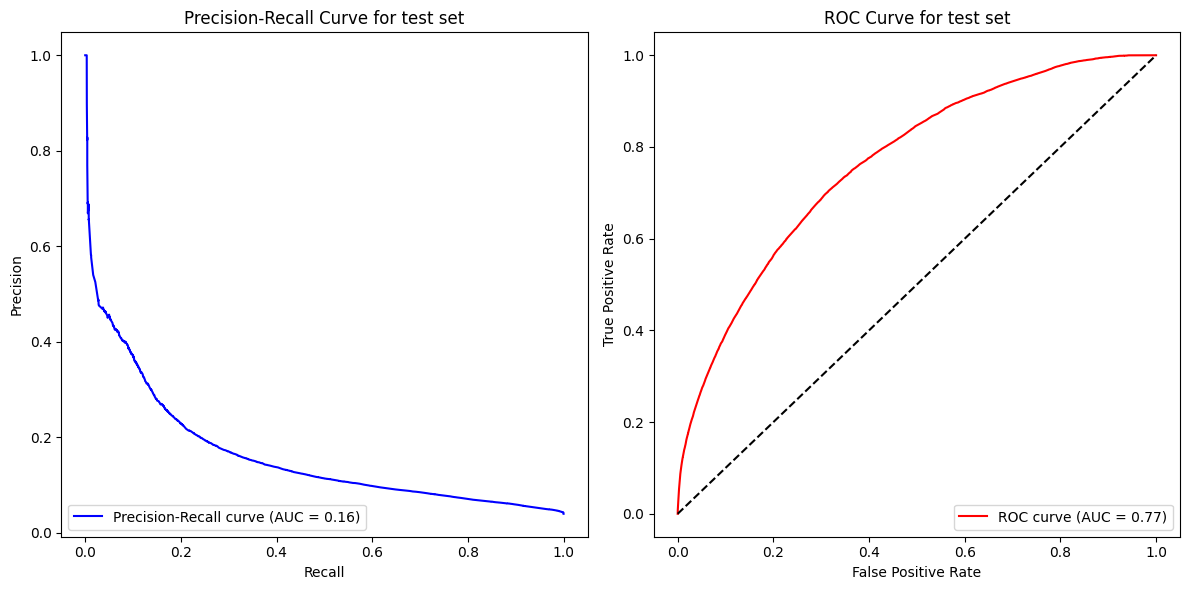

ROC AUC: 0.766
Precision-Recall AUC: 0.16


In [628]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# Subplot for Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(
    recall,
    precision,
    color="b",
    label=f"Precision-Recall curve (AUC = {auc(recall, precision):.2f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for test set")
plt.legend(loc="lower left")

# Subplot for ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color="r", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot(
    [0, 1], [0, 1], color="black", linestyle="--"
)  # Diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for test set")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")
print(f"Precision-Recall AUC: {auc(recall, precision):.2f}")